## Increase Olist customer satisfaction and margin

<ol>Margin = Revenue - cost
<li>Revenue =  20% of sum of product price (excludes freight_value) + 80 BRL by month per seller</li>
<li>cost </li>
<table>
<tr>
<th>review_score</th>
<th>cost (BRL)</th>
</tr>
<tr>
<th>1</th>
<th>100</th>
</tr>
<tr>
<th>2</th>
<th>50</th>
</tr>
<tr>
<th>3</th>
<th>40</th>
</tr>
<tr>
<th>4</th>
<th>0</th>
</tr>
<tr>
<th>5</th>
<th>0</th>    
</tr>
<tr>
<th>+ 500 BRL to acquire one seller</th>
</tr>
</table>
</ol>

In [135]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from olist.data import Olist
from olist.order import Order
from olist.review import Review
from olist.seller import Seller
from olist.product import Product

In [9]:
data = Olist().get_data()
orders = Order().get_training_data()
reviews = Review().get_training_data()
sellers = Seller().get_training_data()
products = Product().get_training_data()

In [33]:
# Get customer data
customers = data['olist_customers_dataset'].copy()
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [103]:
#Merge
# n_orders, price, distance_seller_customer, review score from orders dataset
# customer_state, customer_city from customers dataset
# n_sellers from sellers dataset
dataset = orders \
    .merge(data['olist_orders_dataset'].groupby(['order_id','customer_id']) \
           .first().reset_index()[['order_id','customer_id']], on = 'order_id', how='inner') \
    .merge(customers[['customer_id', 'customer_state','customer_city']], on='customer_id', how='inner') \
    .rename(columns={'customer_state':'state'}) \
    [['order_id','review_score','price','distance_seller_customer','state','customer_city']] \
    .merge(sellers.groupby('seller_state').count().reset_index() \
    [['seller_state','seller_id']].rename(columns={'seller_state':'state', 'seller_id':'n_sellers'}), \
    on = 'state', how = 'inner')
dataset.head()  

,order_id,review_score,price,distance_seller_customer,state,customer_city,n_sellers
0,e481f51cbdc54678b7cc49136f2d6af7,4,29.99,18.063837,SP,sao paulo,1769
1,ad21c59c0840e6cb83a9ceb5573f8159,5,19.90,30.174037,SP,santo andre,1769
2,e69bfb5eb88e0ed6a785585b27e16dbf,5,149.99,111.517726,SP,sorocaba,1769
3,34513ce0c4fab462a55830c0989c7edb,4,98.00,844.977223,SP,sao paulo,1769
4,5ff96c15d0b717ac6ad1f3d77225a350,5,19.90,308.455514,SP,sao paulo,1769


In [98]:
def review_score_cost(x):
    if 0 <= x <= 1.5:
        y = x * 100
    elif 1.5 < x <= 2.5:
        y = x * 50
    elif 2.5 < x <= 3.5:
        y = x * 40
    else:
        y = 0
    return y

In [133]:
df_state = dataset.groupby('state') \
    .agg({'order_id':'count','review_score':'mean', 'price':'sum', \
          'distance_seller_customer':'mean', 'n_sellers':'mean'}) \
    .rename(columns={'order_id':'n_orders'})
df_state['revenue'] = (df_state['price'] * 0.2) + (df_state['n_sellers'] * 80)
df_state['cost'] = (df_state['review_score'].apply(lambda x: review_score_cost(x))) + \
    (df_state['n_sellers'] * 500)
df_state['margin'] = ((df_state['revenue'] - df_state['cost'])*100)/df_state['revenue'] 
df_state_plot = df_state.reset_index()
df_state_plot.head()

,state,n_orders,review_score,price,distance_seller_customer,n_sellers,revenue,cost,margin
0,AM,146,4.212329,22211.74,2644.366290,1,4522.348,500,88.943796
1,BA,3256,3.906634,493252.87,1345.382875,18,100090.574,9000,91.008144
2,CE,1272,3.933962,217860.98,2186.401918,12,44532.196,6000,86.526602
3,DF,1932,4.119048,274269.35,836.451907,30,57253.870,15000,73.800898
4,ES,1991,4.044701,267767.31,801.520572,22,55313.462,11000,80.113340


In [136]:
# Analyse cumsum
df_state_cumsum = df_state.sort_values(by='cost', ascending=False).cumsum().reset_index()
df_state_cumsum.head()

,state,n_orders,review_score,price,distance_seller_customer,n_sellers,revenue,cost,margin
0,SP,40613.0,4.234654,5.082869e+06,249.488134,1769.0,1158093.758,884500.0,23.624491
1,PR,45532.0,8.459903,5.749786e+06,741.246490,2104.0,1318277.254,1052000.0,19.056915
2,MG,56915.0,12.638942,7.304104e+06,1273.928859,2340.0,1648020.726,1170000.0,83.271521
3,SC,60466.0,16.755247,7.811849e+06,1846.336654,2524.0,1764289.826,1262000.0,104.144736
4,RJ,72834.0,20.700024,9.571867e+06,2335.673084,2687.0,2129333.420,1343500.0,181.818636


In [174]:
#plot interactive cumsum
@interact
def plot_distribution(n_states=(0,len(df_state_cumsum))):
    df_state_cumsum_1 = df_state.sort_values(by='cost', ascending=False).iloc[n_states:,:].cumsum().reset_index()
    f, ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].plot(df_state_cumsum_1['state'], df_state_cumsum_1['cost'], label='cost')
    ax[0].plot(df_state_cumsum_1['state'], df_state_cumsum_1['revenue'], label='revenue')
    ax[0].legend()
    ax[1].plot(df_state_cumsum_1['state'], df_state_cumsum_1['n_orders'], label='n_orders')
    ax[1].legend()

interactive(children=(IntSlider(value=11, description='n_states', max=22), Output()), _dom_classes=('widget-in…

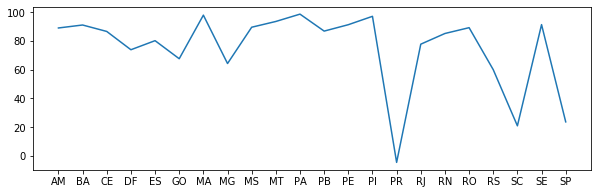

In [134]:
# %Margin for each state
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(df_state_plot.state, df_state_plot.margin)

### Conclusion
So can money make you happy after all?
I think that it has the potential to help you on your quest for happiness. But I don't think that money itself makes you happy, and I certainly don't think that anyone I know has the self control to keep themselves away from anti-social selfish spending. Is money bad? No, I don't think so. Can you be happy and have money? Yes, that's possible. But can you be without a possession or a cent in the world, and be the happiest man alive? I think you can be. If you have a solid relationship with God and with other people, I think that you can be happy no matter what life throws at you.